# Project: Identify Fraud from Enron Email.

#### by Djamshid Azizov


### Introduction and Overview.

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 
In this project, I am going to build a person of interest identifier based on financial and email data made public as a result of the Enron scandal.
The persons of interest in the fraud case means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

### Data source.

This  dataset  consists  from  ENRON  emails  and  financial  data publicly available in https://www.cs.cmu.edu/~./enron/.for. It is collected and prepared by the CALO Project (A Cognitive Assistant that Learns and Organizes). The financial data was published in Payments to Insiders report by FindLaw and available at www.findlaw.com

###### 1. Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those? 

There are a few major steps to get the goal of the project.
This is following steps:
1. The process of data exploration (learning, cleaning and preparing the data).
2. Feature selecting/engineering (selecting the features which influence mostly on the target, create new features (which explains the target the better than existing).
3. Picking/tuning of the supervised machine learning algorithm 
4. Validating it to get the accurate person of interest identifier model.

The dataset contains about 146 users (18 of them are considered POIs, while 128 are non-POIs) mostly real emails exchanged by top managers of Enron.

We can use machine learning on this dataset to answer questions like "can we identify patterns in the emails?", using regression we will be able to understand the relationship between the people's salary and their bonuses for example, and using clustering we can identify who was a member of the board of directors, and who is just an employee.

The dataset has 21 features, 
they are poi, salary, bonus,long_term_incentive, deferred_income, deferral_payments, loan_advances, other, expenses, director_fees, total_payments, exercised_stock_options, restricted_stock, restricted_stock_deferred, total_stock_value, to_messages, from_messages, from_this_person_to_poi, from_poi_to_this_person, email_address, shared_receipt_with_poi.
                

In [1]:
#!/usr/bin/python
from IPython.display import Image
import matplotlib.pyplot as plt
import sys
import pickle
from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import numpy as np
import pandas as pd
sys.path.append("../tools/")
import pprint

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'expenses', 'total_stock_value',
                 'bonus', 'from_poi_to_this_person', 'shared_receipt_with_poi']


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

C:\Users\Owner\Anaconda2\envs\py2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Owner\Anaconda2\envs\py2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Data Exploration.

First let's check how our data dictionary structered 

In [16]:
df = pd.DataFrame.from_dict(data_dict.keys())

print df

                        0
0              METTS MARK
1           BAXTER JOHN C
2          ELLIOTT STEVEN
3        CORDES WILLIAM R
4          HANNON KEVIN P
5     MORDAUNT KRISTINA M
6        MEYER ROCKFORD G
7         MCMAHON JEFFREY
8        HORTON STANLEY C
9         PIPER GREGORY F
10        HUMPHREY GENE E
11         UMANOFF ADAM S
12      BLACHMAN JEREMY M
13           SUNDE MARTIN
14           GIBBS DANA R
15        LOWRY CHARLES P
16         COLWELL WESLEY
17          MULLER MARK S
18     JACKSON CHARLENE R
19     WESTFAHL RICHARD K
20       WALTERS GARETH W
21      WALLS JR ROBERT H
22         KITCHEN LOUISE
23            CHAN RONNIE
24          BELFER ROBERT
25     SHANKMAN JEFFREY A
26          WODRASKA JOHN
27   BERGSIEKER RICHARD P
28        URQUHART JOHN A
29        BIBI PHILIPPE A
..                    ...
116     REYNOLDS LAWRENCE
117   DIMICHELE RICHARD G
118      BHATNAGAR SANJAY
119      CARTER REBECCA C
120     BUCHANAN HAROLD G
121             YEAP SOON
122        M

In [6]:
print "There are ", len(data_dict.keys()), " users in Enron Dataset."

There are  146  users in Enron Dataset.


We can see all features in Enron dataset on the example of real user.

In [12]:
df = pd.DataFrame.from_dict(data_dict['LAY KENNETH L'],orient = 'index')
print df

                                               0
salary                                   1072321
to_messages                                 4273
deferral_payments                         202911
total_payments                         103559793
exercised_stock_options                 34348384
bonus                                    7000000
restricted_stock                        14761694
shared_receipt_with_poi                     2411
restricted_stock_deferred                    NaN
total_stock_value                       49110078
expenses                                   99832
loan_advances                           81525000
from_messages                                 36
other                                   10359729
from_this_person_to_poi                       16
poi                                         True
director_fees                                NaN
deferred_income                          -300000
long_term_incentive                      3600000
email_address       


Above some features have missing values NaNs. According to the financial data from FindLaw,  values NaNs represent values of 0 but not the missing value. That's why I going to replace all NaNs with 0s.


Below we can see each feature and how many values it's missing:

missing values:  {'salary': 51, 'to_messages': 60, 'deferral_payments': 107, 'total_payments': 21, 'exercised_stock_options': 44, 'bonus': 64, 'director_fees': 129, 'restricted_stock_deferred': 128, 'total_stock_value': 20, 'expenses': 51, 'from_poi_to_this_person': 60, 'loan_advances': 142, 'from_messages': 60, 'other': 53, 'email_address': 35, 'from_this_person_to_poi': 60, 'poi': 0, 'long_term_incentive': 80, 'shared_receipt_with_poi': 60, 'restricted_stock': 36, 'deferred_income': 97}

The following features has the biggest missing value. They are;
'loan_advances': 142, 'director_fees': 129, 'restricted_stock_deferred': 128. 

We can't remove these features, as they have meaningful reason for our data. From above example we can see user LAY KENNETH L is a person of interest, and the one who received loan_advances. That's why the information present in the feature with the biggest missing value is relevant to our investigation. 

## Outlier Investigation 

To identify outliers in the financial data, we are going to plot and see outlier in salary vs. bonus features.


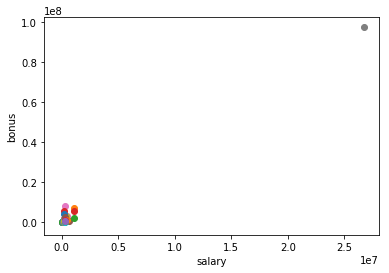

In [3]:
def scatter_plot(dataset, feature1, feature2):
    data = featureFormat(dataset, [feature1, feature2])
    for p in data:
        x = p[0]
        y = p[1]
        plt.scatter(x, y)

    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()
    
# identify outliers
scatter_plot(data_dict, "salary", "bonus")

Using the FindLaw data, we can see two outliers. These are 'total' and 'the travel agency in the park' values. They are not sensible information for our analysis that's why I'm going to remove them. Then after that we will have relatively small number of dataset. Now, It is going to be 144 

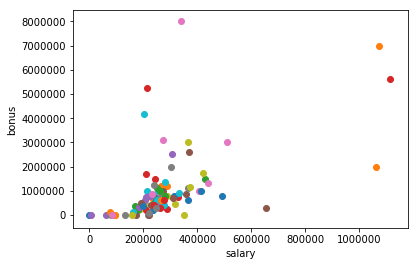

In [11]:
# remove outliers
map(data_dict.pop, ["TOTAL", "THE TRAVEL AGENCY IN THE PARK"])
scatter_plot(data_dict, "salary", "bonus")


# Optimize Feature Selection/Engineering

###### 2. What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  

## Create new features.

In the dataset there are the number of emails sent to POI’s and received from POI’s for most of the employees. If an employees sent or received from POI's a lot of emails so then the quantity of them would be large as well. This is why I created these two new features: - fraction_from_poi, which represents the ratio of the messages from poi to this person against all messages sent to this person, and fraction_to_poi, ratio from this person to poi against all messages from this person. 

This code computes the fraction of messages to/from that person that are from/to a POI, given a number of messages to/from POI (numerator) and number of all messages to/from a person (denominator).



In [ ]:
# create new features
def computeFraction(poi_messages, all_messages):
    fraction = 0
    if poi_messages != 'NaN' and all_messages != 'NaN':
        fraction = poi_messages/float(all_messages)

    return fraction

# take second element for sort
def takeSecond(elem):
    return elem[1]

for employee in my_dataset:
    from_poi_to_this_person = my_dataset[employee]['from_poi_to_this_person']
    to_messages = my_dataset[employee]['to_messages']
    fraction_from_poi = computeFraction(from_poi_to_this_person, to_messages)
    # print fraction_from_poi
    my_dataset[employee]['fraction_from_poi'] = fraction_from_poi

    from_this_person_to_poi = my_dataset[employee]['from_this_person_to_poi']
    from_messages = my_dataset[employee]['from_messages']
    fraction_to_poi = computeFraction(from_this_person_to_poi, from_messages)
    my_dataset[employee]['fraction_to_poi'] = fraction_to_poi

new_features_list = total_number_of_features 
new_features_list.remove('email_address')
new_features_list =  new_features_list + ['fraction_from_poi', 'fraction_to_poi']
print new_features_list

print 'total number of features after creating new features = ', len(new_features_list)


I used the above code to calculate the fraction for each employee in dataset, and then I added them to the features_list, to pass the SelectKBest function for features selection.


## Univariate Feature Selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator.
In order to choose the best features, I used SelectKBest(an automated feature selection function), which selects the k highest scoring features. Then the function returned the below scores for all the features.

### SelectKBest scores:  
[('exercised_stock_options', 24.815079733218194),
('total_stock_value', 24.182898678566879), 
('bonus', 20.792252047181535), 
('salary', 18.289684043404513),
('fraction_to_poi', 16.409712548035792),
('deferred_income', 11.458476579280369),
('long_term_incentive', 9.9221860131898225),
('restricted_stock', 9.2128106219771002),
('total_payments', 8.7727777300916756),
('shared_receipt_with_poi', 8.589420731682381),
('loan_advances', 7.1840556582887247), 
('expenses', 6.0941733106389453), 
('from_poi_to_this_person', 5.2434497133749582), 
('other', 4.1874775069953749), 
('fraction_from_poi', 3.1280917481567192), 
('from_this_person_to_poi', 2.3826121082276739),
('director_fees', 2.1263278020077054), 
('to_messages', 1.6463411294420076), 
('deferral_payments', 0.22461127473600989), 
('from_messages', 0.16970094762175533),
('restricted_stock_deferred', 0.065499652909942141)]


I took the first 10 features (k = 10) along with POI as they obtained the highest scores from SelectKBest results. 

## Properly scale features

Since our selected features have different values, I need to transform them. I am using MinMaxScaler from sklearn to scale all our selected features to a given range.

In [ ]:
# Features scaling
# dataset without new features
from sklearn import preprocessing
data = featureFormat(my_dataset, kBest_features, sort_keys = True)
labels, features = targetFeatureSplit(data)
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)


# Pick and Tune an Algorithm

###### What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  

I tried to use algorithms Gaussian Naive-Bayes, Decision Tree Classifier, Support vector machines Then ended up using Gaussian Naive-Bayes as it scored the highest evaluation metrics.

The scores obtained for them are as follows:

## NAIVE BAYES 
##### original features
accuracy: 0.840697674419
precision: 0.373100198413
recall: 0.326122835498
##### new features 
accuracy: 0.834302325581
precision: 0.356977362915
recall: 0.318538510101
## DECISION TREE 
#####  original features 
accuracy: 0.800872093023
precision: 0.268834776335
recall: 0.271361381674
#####  new features 
accuracy: 0.815406976744
precision: 0.2933746115
recall: 0.306416396104
## SVM 
##### original features 
accuracy: 0.860755813953
precision: 0.159375
recall: 0.0740029761905
##### new features 
accuracy: 0.85988372093
precision: 0.195814393939
recall: 0.0668700396825

We can also notice from above scores, that matching the performance of each algorithm with the original features (without new features) to the performance while adding the new features differs from each other. 
As we can see algorithm Decision Tree performed better while including the new features, but algorithms Naive Bayes and SVM performed worse with the new features.


##### What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  

A crucial part of selecting a machine learning algorithm is to adjust it’s parameters in order to maximize the evaluation metrics. If the parameters are not properly tuned, the algorithm can underfit or overfit the data, therefore producing not the best results.
Most classifiers come with a set of parameters (with default values) which affect the model, and are passed as arguments to the constructor. Typical examples include C, kernel and gamma for SVM Classifier for example. Tuning the parameters of a classifier (usually referred to as hyperparameters) means to optimize the values of those parameters to enable the algorithm to perform its best (Hyperparameter Optimization). It's a final step in the process of applied machine learning before presenting results. If this step is not done well, it can lead to the model misfitting the data.



## Tune the algorithm

I used GridSearchCV from sklearn for parameter tuning in the algorithms that had parameters (SVM, Decision Tree). Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.

I created the below code to tune the algorithm using grid search. It prints out the best hyperparameters for the model after performing the tuning for 80 iterations, along with the average evaluation metrics results (accuracy, percision, recall).




In [ ]:
# Algorithm tuning
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

def tune_params(grid_search, features, labels, params, iters = 80):
    acc = []
    pre = []
    recall = []
    for i in range(iters):
        features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size = 0.3, random_state = i)
        grid_search.fit(features_train, labels_train)
        predicts = grid_search.predict(features_test)

        acc = acc + [accuracy_score(labels_test, predicts)] 
        pre = pre + [precision_score(labels_test, predicts)]
        recall = recall + [recall_score(labels_test, predicts)]
    print "accuracy: {}".format(np.mean(acc))
    print "precision: {}".format(np.mean(pre))
    print "recall: {}".format(np.mean(recall))

    best_params = grid_search.best_estimator_.get_params()
    for param_name in params.keys():
        print("%s = %r, " % (param_name, best_params[param_name]))


#### Tuning Decision Tree Classifier


In [ ]:
# Decision Tree
from sklearn import tree
DT_clf = tree.DecisionTreeClassifier()
DT_param = {'criterion':('gini', 'entropy'),
'splitter':('best','random')}
DT_grid_search = GridSearchCV(estimator = DT_clf, param_grid = DT_param)



#### Support Vector Machines Classifier

In [ ]:
# Support Vector Machines
from sklearn import svm
SVM_clf = svm.SVC()
SVM_param = {'kernel':('linear', 'rbf', 'sigmoid'),
'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
'C': [0.1, 1, 10, 100, 1000]}
SVM_grid_search = GridSearchCV(estimator = SVM_clf, param_grid = SVM_param)



## Validate and Evaluate

###### What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  


Validation is a strategy  to separate our data into trainig and testing dataset initially. This allows us to train our model on a training dataset and then test that model on an independent test dataset. This reduces the problem of over fitting our model to the dataset that we initially trained it on. if we only tested the model on our trainnig dataset we wouldn't know how well our model would perform on a new, unknown dataset. While validating on test set, if we got much poorer results we would know that there is a chance overfitted our model to the training dataset. 
I used tester.py's Stratified Shuffle Split cross validation as an alternate method to gauge my algorithm's performance. Because the Enron data set is so small, this type of cross validation was useful because it essentially created multiple datasets out of a single one to get more accurate results.
Using Cross Validation train_test_split function I splitted 30% of my dataset as for testing, while the training set was 70%. then I used sklearn.metrics accuracy, precision and recall scores to validate my algorithms.



In [ ]:
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size = 0.3, random_state = 42)

from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy_score(labels_test, predicts)
precision_score(labels_test, predicts)
recall_score(labels_test, predicts)

###### Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. 

The two notable evaluation metrics for this POI identifier are precision and recall. 

My chosen algorithm is Naive Bayes, which resulted in  precision of 0.36639 and recall of 0.31400. 

#### Precision

True Positive / (True Positive + False Positive). Out of all the items labeled as positive, how many truly belong to the positive class.

#### Recall

True Positive / (True Positive + False Negative). Out of all the items that are truly positive, how many were correctly classified as positive. Or simply, how many positive items were 'recalled' from the dataset.

In the context to this project:

Precision is a metric that measures an algorithm's power to classify true positives from all cases that are classified as positives. A precision of 0.36 means that among the total 100 persons classified as POIs, 36 persons are actually POIs. Recall is a metric that measures an algorithm's power to classify true positives over all cases that are actually positives. A recall of 0.31 means that among 100 true POIs existing in the dataset, 31 POIs are correctly classified as POIs

